In [2]:
using LinearAlgebra
using Plots
using Random

# Функция для вычисления степени диагонального преобладания
function diagonal_dominance_degree(A)
    n = size(A, 1)
    dominance = -Inf  # Минимальное значение по всем строкам
    for i in 1:n
        diag_elem = abs(A[i, i])
        row_sum = sum(abs.(A[i, :])) - diag_elem
        dominance = max(dominance, diag_elem - row_sum)
    end
    return dominance
end

# Функция для генерации матрицы с заданной степенью диагонального преобладания
function generate_matrix_with_dominance(n, target_dominance)
    A = randn(n, n)
    
    # Делаем матрицу с заданным диагональным преобладанием
    for i in 1:n
        row_sum = sum(abs.(A[i, :])) - abs(A[i, i])
        if target_dominance >= 0
            A[i, i] = sign(A[i, i]) * (row_sum + target_dominance + abs(randn() * 0.1))
        else
            A[i, i] = sign(A[i, i]) * (row_sum + target_dominance - abs(randn() * 0.1))
        end
    end
    
    return A
end

A = generate_matrix_with_dominance(3, 2)

3×3 Matrix{Float64}:
 -4.06899   -1.41782  0.59993
  0.884856  -3.29495  0.327135
 -1.67503    1.20074  4.91334

In [3]:
# проверим правильность работы функции вычисления степени диагонального преобразования
diagonal_dominance_degree(A)

2.082958237526759

In [4]:
# классический метод гаусса без перестановок
function gauss_classic(A, b)
    n = size(A, 1)
    A_ext = hcat(A, b)
    
    # Прямой ход
    for k in 1:n-1
        for i in k+1:n
            factor = A_ext[i, k] / A_ext[k, k]
            for j in k:n+1
                A_ext[i, j] -= factor * A_ext[k, j]
            end
        end
    end
    
    # Обратный ход
    x = zeros(n)
    for i in n:-1:1
        x[i] = A_ext[i, n+1]
        for j in i+1:n
            x[i] -= A_ext[i, j] * x[j]
        end
        x[i] /= A_ext[i, i]
    end
    
    return x
end

gauss_classic (generic function with 1 method)

In [5]:
# перестановка строк 

function gauss_row_pivot(A, b)
    n = size(A, 1)
    A_ext = hcat(A, b) # создаем расширенную матрицу
    
    # Прямой ход с выбором главного элемента по строкам
    for k in 1:n-1
        # Поиск максимального элемента в столбце
        max_row = k
        max_val = abs(A_ext[k, k])
        for i in k+1:n
            if abs(A_ext[i, k]) > max_val
                max_val = abs(A_ext[i, k])
                max_row = i
            end
        end
        
        # Перестановка строк
        if max_row != k
            A_ext[[k, max_row], :] = A_ext[[max_row, k], :]
        end
        
        # Исключение
        for i in k+1:n
            factor = A_ext[i, k] / A_ext[k, k]
            for j in k:n+1
                A_ext[i, j] -= factor * A_ext[k, j]
            end
        end
    end
    
    # Обратный ход
    x = zeros(n)
    for i in n:-1:1
        x[i] = A_ext[i, n+1]
        for j in i+1:n
            x[i] -= A_ext[i, j] * x[j]
        end
        x[i] /= A_ext[i, i]
    end
    
    return x
end

gauss_row_pivot (generic function with 1 method)

In [6]:
# перестановка столбцов

function gauss_col_pivot(A, b)
    n = size(A, 1)
    A_ext = hcat(A, b)
    col_order = collect(1:n)  # Для отслеживания перестановок столбцов
    
    # Прямой ход с выбором главного элемента по столбцам
    for k in 1:n-1
        # Поиск максимального элемента в строке
        max_col = k
        max_val = abs(A_ext[k, k])
        for j in k+1:n
            if abs(A_ext[k, j]) > max_val
                max_val = abs(A_ext[k, j])
                max_col = j
            end
        end
        
        # Перестановка столбцов
        if max_col != k
            A_ext[:, [k, max_col]] = A_ext[:, [max_col, k]]
            col_order[k], col_order[max_col] = col_order[max_col], col_order[k]
        end
        
        # Исключение
        for i in k+1:n
            factor = A_ext[i, k] / A_ext[k, k]
            for j in k:n+1
                A_ext[i, j] -= factor * A_ext[k, j]
            end
        end
    end
    
    # Обратный ход
    x = zeros(n)
    for i in n:-1:1
        x[i] = A_ext[i, n+1]
        for j in i+1:n
            x[i] -= A_ext[i, j] * x[j]
        end
        x[i] /= A_ext[i, i]
    end
    
    # Восстановление порядка переменных
    x_ordered = zeros(n)
    for i in 1:n
        x_ordered[col_order[i]] = x[i]
    end
    
    return x_ordered
end

gauss_col_pivot (generic function with 1 method)

In [7]:
# комбинированный метод

function gauss_full_pivot(A, b)
    n = size(A, 1)
    A_ext = hcat(A, b)
    row_order = collect(1:n)
    col_order = collect(1:n)
    
    # Прямой ход с полным выбором главного элемента
    for k in 1:n-1
        # Поиск максимального элемента в подматрице
        max_row, max_col = k, k
        max_val = abs(A_ext[k, k])
        for i in k:n
            for j in k:n
                if abs(A_ext[i, j]) > max_val
                    max_val = abs(A_ext[i, j])
                    max_row, max_col = i, j
                end
            end
        end
        
        # Перестановка строк
        if max_row != k
            A_ext[[k, max_row], :] = A_ext[[max_row, k], :]
            row_order[k], row_order[max_row] = row_order[max_row], row_order[k]
        end
        
        # Перестановка столбцов
        if max_col != k
            A_ext[:, [k, max_col]] = A_ext[:, [max_col, k]]
            col_order[k], col_order[max_col] = col_order[max_col], col_order[k]
        end
        
        # Исключение
        for i in k+1:n
            factor = A_ext[i, k] / A_ext[k, k]
            for j in k:n+1
                A_ext[i, j] -= factor * A_ext[k, j]
            end
        end
    end
    
    # Обратный ход
    x = zeros(n)
    for i in n:-1:1
        x[i] = A_ext[i, n+1]
        for j in i+1:n
            x[i] -= A_ext[i, j] * x[j]
        end
        x[i] /= A_ext[i, i]
    end
    
    # Восстановление порядка переменных
    x_ordered = zeros(n)
    for i in 1:n
        x_ordered[col_order[i]] = x[i]
    end
    
    return x_ordered
end

gauss_full_pivot (generic function with 1 method)

In [8]:
function test_gauss_method(A, x_true, method)
    b = A * x_true
    x_computed = method(A, b)
    error = norm(x_computed - x_true)
    return error
end

function library_method(A, b)
    return A \ b
end

library_method (generic function with 1 method)

In [9]:
n = 5
dominance = 2.0
A = generate_matrix_with_dominance(n, dominance)
x_true = randn(n)
b = A * x_true

x_lib = library_method(A, b)
error_lib = norm(x_lib - x_true)

error_classic = test_gauss_method(A, x_true, gauss_classic)
error_row = test_gauss_method(A, x_true, gauss_row_pivot)
error_col = test_gauss_method(A, x_true, gauss_col_pivot)
error_full = test_gauss_method(A, x_true, gauss_full_pivot)

println("Истинный x: ", x_true)
println("Библиотечный x: ", x_lib)
println("Ошибка библиотечная: ", error_lib)
println("Ошибка классический: ", error_classic)
println("Ошибка по строкам: ", error_row)
println("Ошибка по столбцам: ", error_col)
println("Ошибка комбинированного: ", error_full)

Истинный x: [0.9721145432575431, 0.49902595349025636, -0.27671656919380383, -0.44788412060163146, -0.5720072660706376]
Библиотечный x: [0.972114543257543, 0.49902595349025636, -0.27671656919380383, -0.4478841206016315, -0.5720072660706377]
Ошибка библиотечная: 1.6653345369377348e-16
Ошибка классический: 3.090730095650652e-16
Ошибка по строкам: 3.090730095650652e-16
Ошибка по столбцам: 3.090730095650652e-16
Ошибка комбинированного: 1.2412670766236366e-16


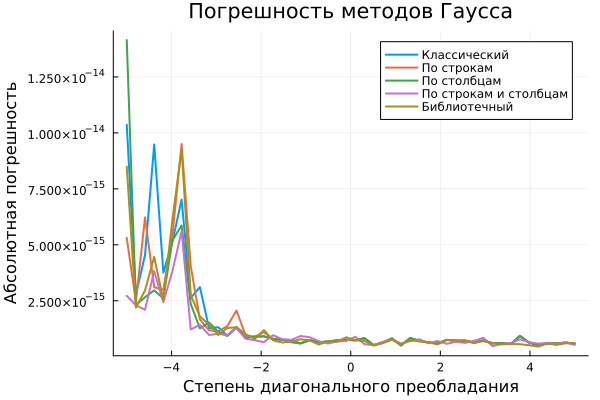

In [10]:
dominances = range(-5.0, 5.0, length=50)
errors_classic = Float64[]
errors_row = Float64[]
errors_col = Float64[]
errors_full = Float64[]
errors_lib = Float64[]

n = 10
num_trials = 5

for dom in dominances
    err_c, err_r, err_co, err_f, err_l = 0.0, 0.0, 0.0, 0.0, 0.0
    for _ in 1:num_trials
        A = generate_matrix_with_dominance(n, dom)
        x_true = randn(n)
        
        err_c += test_gauss_method(A, x_true, gauss_classic)
        err_r += test_gauss_method(A, x_true, gauss_row_pivot)
        err_co += test_gauss_method(A, x_true, gauss_col_pivot)
        err_f += test_gauss_method(A, x_true, gauss_full_pivot)
        
        b = A * x_true
        x_lib = library_method(A, b)
        err_l += norm(x_lib - x_true)
    end
    push!(errors_classic, err_c / num_trials)
    push!(errors_row, err_r / num_trials)
    push!(errors_col, err_co / num_trials)
    push!(errors_full, err_f / num_trials)
    push!(errors_lib, err_l / num_trials)
end

plot(dominances, errors_classic, label="Классический", lw=2)
plot!(dominances, errors_row, label="По строкам", lw=2)
plot!(dominances, errors_col, label="По столбцам", lw=2)
plot!(dominances, errors_full, label="По строкам и столбцам", lw=2)
plot!(dominances, errors_lib, label="Библиотечный", lw=2)
xlabel!("Степень диагонального преобладания")
ylabel!("Абсолютная погрешность")
title!("Погрешность методов Гаусса")
plot!(grid = true)

In [13]:
# Расчет погрешности от округлений
function rounding_error(A, x_true, method)
    try
        b = A * x_true
        
        x64 = method(Float64.(A), Float64.(b))
        err64 = norm(x64 - x_true)
        
        x32 = method(Float32.(A), Float32.(b))
        err32 = norm(Float64.(x32) - x_true)
        
        rounding_err = abs(err32 - err64)
        return rounding_err
    catch
        return Inf
    end
end

n = 4
dominance = 2.0
A = generate_matrix_with_dominance(n, dominance)
x_true = randn(n)

rounding_classic = rounding_error(A, x_true, gauss_classic)
rounding_row = rounding_error(A, x_true, gauss_row_pivot)
rounding_col = rounding_error(A, x_true, gauss_col_pivot)
rounding_full = rounding_error(A, x_true, gauss_full_pivot)
rounding_lib = rounding_error(A, x_true, library_method)

println("Погрешность от округлений (классический): ", rounding_classic)
println("Погрешность от округлений (по строкам): ", rounding_row)
println("Погрешность от округлений (по столбцам): ", rounding_col)
println("Погрешность от округлений (по строкам и столбцам): ", rounding_full)
println("Погрешность от округлений (библиотечный): ", rounding_lib)
println()

# Расчет погрешности от возмущений матрицы и правой части
function perturbation_error(A, b, x_true, method, epsilon=1e-5)
    try
        x_orig = method(A, b)
        
        A_pert = A + epsilon * randn(size(A))
        x_pert_A = method(A_pert, b)
        err_pert_A = norm(x_pert_A - x_orig)
        
        b_pert = b + epsilon * randn(size(b))
        x_pert_b = method(A, b_pert)
        err_pert_b = norm(x_pert_b - x_orig)
        
        return err_pert_A, err_pert_b
    catch
        return Inf, Inf
    end
end

n = 3
dominance = 2.0
A = generate_matrix_with_dominance(n, dominance)
x_true = randn(n)
b = A * x_true

err_A_classic, err_b_classic = perturbation_error(A, b, x_true, gauss_classic)
err_A_row, err_b_row = perturbation_error(A, b, x_true, gauss_row_pivot)
err_A_col, err_b_col = perturbation_error(A, b, x_true, gauss_col_pivot)
err_A_full, err_b_full = perturbation_error(A, b, x_true, gauss_full_pivot)
err_A_lib, err_b_lib = perturbation_error(A, b, x_true, library_method)

println("Погрешность от возмущения A (классический): ", err_A_classic)
println("Погрешность от возмущения b (классический): ", err_b_classic)
println("Погрешность от возмущения A (по строкам): ", err_A_row)
println("Погрешность от возмущения b (по строкам): ", err_b_row)
println("Погрешность от возмущения A (по столбцам): ", err_A_col)
println("Погрешность от возмущения b (по столбцам): ", err_b_col)
println("Погрешность от возмущения A (по строкам и столбцам): ", err_A_full)
println("Погрешность от возмущения b (по строкам и столбцам): ", err_b_full)
println("Погрешность от возмущения A (библиотечный): ", err_A_lib)
println("Погрешность от возмущения b (библиотечный): ", err_b_lib)

Погрешность от округлений (классический): 4.4893387868341435e-8
Погрешность от округлений (по строкам): 4.4893387868341435e-8
Погрешность от округлений (по столбцам): 4.4893387868341435e-8
Погрешность от округлений (по строкам и столбцам): 4.477009696029872e-8
Погрешность от округлений (библиотечный): 2.9380708507804335e-8

Погрешность от возмущения A (классический): 5.496605784797102e-6
Погрешность от возмущения b (классический): 7.335939426242935e-6
Погрешность от возмущения A (по строкам): 1.3701715345314322e-5
Погрешность от возмущения b (по строкам): 6.247168009945051e-6
Погрешность от возмущения A (по столбцам): 2.0529832921488246e-6
Погрешность от возмущения b (по столбцам): 9.12155024318933e-6
Погрешность от возмущения A (по строкам и столбцам): 3.417241789720428e-6
Погрешность от возмущения b (по строкам и столбцам): 1.1510478297165562e-5
Погрешность от возмущения A (библиотечный): 3.85980316675534e-6
Погрешность от возмущения b (библиотечный): 3.5723857358675285e-6
